In [2]:
#import basic libraries
import pandas as pd
import numpy as np
import sys
#import libraries needed for the model and data preprocessing
import sklearn.metrics as sk_metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import sklearn.preprocessing as preproc
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import MinMaxScaler
#import visualisation libraries
import matplotlib.pyplot as plt
#get the models from the wrapper.py file in the nam folder. 
sys.path.append('../')
import nam.wrapper as nam_models

/Users/raikku/BachelorThesisCode/NamJupyter/NamJupyter/notebooks/../nam/trainer/trainer.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
#get the data
metro_data = pd.read_csv('../../../Data/Metro/Metro_Interstate_Traffic_Volume.csv')

In [4]:
metro_data['weather_main'].unique()

array(['Clouds', 'Clear', 'Rain', 'Drizzle', 'Mist', 'Haze', 'Fog',
       'Thunderstorm', 'Snow', 'Squall', 'Smoke'], dtype=object)

In [5]:
weather_dict = {'Clear': 0, 'Haze': 1, 'Mist': 2, 'Fog': 3, 'Squall':4, 'Clouds':5,
                       'Drizzle': 6, 'Rain': 7, 'Snow': 8, 'Smoke': 9, 'Thunderstorm': 10}

In [6]:
metro_data = metro_data.replace({'weather_main': weather_dict})

In [7]:
#remove faulty measurements
metro_data = metro_data[metro_data['temp'] != 0] #temp is measured in kelvin. It is not possible that there was a day where the temperature was zero kelvin
metro_data = metro_data[metro_data['rain_1h'] != metro_data['rain_1h'].max()] #max value was 9831mm for an hour of rainfall on a m^2 space. This would be a storm of apocalypsic proportions

In [8]:
#If there is no holiday assign it the value 0 else give the value 1
metro_data['holiday'] = metro_data['holiday'].apply(lambda x: 0 if x == 'None' else 1)

In [9]:
#convert the date_time column to pandas date time and get date, month and hour as their own columns
metro_data['date_time'] = pd.to_datetime(metro_data['date_time'])
metro_data['day'] = metro_data['date_time'].dt.day
metro_data['month'] = metro_data['date_time'].dt.month
metro_data['time'] = metro_data['date_time'].dt.hour

In [10]:
#assign the target and training data
traffic = metro_data['traffic_volume'] / 100
x_metro = metro_data.drop(['traffic_volume', 'weather_description', 'date_time'], axis = 1)

In [11]:
#split the data to train, val and test
X_train, X_test, y_train, y_test = train_test_split(x_metro, traffic, test_size = 0.15)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = (0.15 /(0.15 + 0.7)))

In [12]:
#get the column names of numerical and categorical columns. We have only one catecorigal column, "weather_main"
numerical_cols = [col for col in X_train.columns if X_train[col].dtype == np.float64 or X_train[col].dtype == np.int64]
numerical_cols.remove('holiday')


In [13]:
#scale the numerical columns and encode the catecorigal columns
ct = ColumnTransformer([
    ("MinMax scaling numerical variables", preproc.MinMaxScaler((-1, 1)), numerical_cols)
], remainder='passthrough')
ct.fit(X_train)
X_train = ct.transform(X_train)
X_val = ct.transform(X_val)
X_test = ct.transform(X_test)

In [14]:
columns_for_labeling = numerical_cols + ['holiday']
columns_for_labeling

['temp',
 'rain_1h',
 'snow_1h',
 'clouds_all',
 'weather_main',
 'day',
 'month',
 'time',
 'holiday']

In [15]:
x_dataframe = pd.DataFrame(data = X_train, columns=columns_for_labeling)
x_dataframe

,temp,rain_1h,snow_1h,clouds_all,weather_main,day,month,time,holiday
0,0.070486,-1.000000,-1.0,0.50,0.0,0.466667,0.818182,0.478261,0.0
1,-0.323635,-1.000000,-1.0,0.80,0.6,-0.466667,1.000000,-0.217391,0.0
2,0.310738,-1.000000,-1.0,-0.98,-1.0,-0.733333,0.272727,-0.565217,0.0
3,0.634613,-1.000000,-1.0,-1.00,-1.0,0.200000,0.090909,0.739130,0.0
4,0.008098,-1.000000,-1.0,-0.60,0.0,-0.333333,0.636364,-1.000000,0.0
...,...,...,...,...,...,...,...,...,...
33730,-0.159568,-1.000000,-1.0,0.80,0.0,0.000000,0.818182,-0.130435,0.0
33731,-0.529394,-1.000000,-1.0,-0.98,-1.0,-0.666667,-1.000000,0.130435,0.0
33732,-0.126875,-1.000000,-1.0,0.80,0.6,-0.333333,-0.636364,-0.478261,0.0
33733,0.381524,-0.986338,-1.0,0.50,0.4,0.066667,0.454545,0.565217,0.0


In [ ]:
#create and fit the model
nam_reg = nam_models.NAMRegressor(
                lr=0.00161,
                output_reg=0.02,
                metric='RMSE',
                num_learners=10
            )
nam_reg.fit(X_train, y_train)

In [45]:
#evaluate the model
traffic_pred = nam_reg.predict(X_test)
score = sk_metrics.mean_squared_error(y_test, traffic_pred, squared=False)
print("RMSE score is: ", score)

RMSE score is:  10.314310745142985


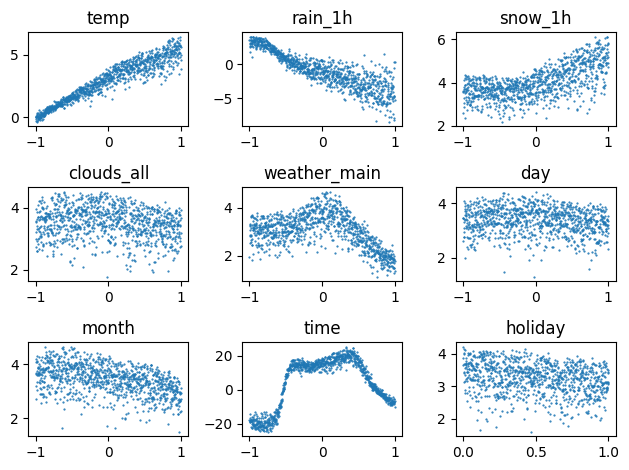

In [18]:
figure, axis = plt.subplots(3, 3)
counter = 0
for i in range(3):
    for j in range(3):
        column_of_data = X_train[:, counter]
        vis_data = nam_reg.plot(counter, column_of_data)
        axis[i, j].scatter(vis_data['x'], vis_data['y'], s=0.3)
        axis[i, j].set_title(columns_for_labeling[counter])
        counter += 1
plt.tight_layout()

In [19]:
score_metric = ['neg_root_mean_squared_error']
r = permutation_importance(nam_reg, X_test, y_test,n_repeats = 20, scoring = score_metric, random_state=42)


In [20]:
r['neg_root_mean_squared_error']['importances_mean']

array([ 9.32080588e-02, -1.55583268e-02, -1.84337810e-02, -2.19167876e-02,
        4.56563609e-03, -2.03731269e-02,  4.32776937e-03,  1.41779747e+01,
       -2.88214599e-02])

In [21]:
sorted(r['neg_root_mean_squared_error']['importances_mean'])
#Time, temp, and weather_main are the most important features according to the model

[-0.02882145994429184,
 -0.02191678755070452,
 -0.020373126850095603,
 -0.01843378101099491,
 -0.015558326824820501,
 0.004327769372533119,
 0.004565636086789749,
 0.09320805882666035,
 14.177974658995879]

In [31]:
time_data = nam_reg.plot(7, X_train[:, 7])
temp_data = nam_reg.plot(0, X_train[:, 0])
weather_data = nam_reg.plot(4, X_train[:, 4])
%store time_data
%store temp_data
%store weather_data



Stored 'time_data' (dict)
Stored 'temp_data' (dict)
Stored 'weather_data' (dict)


In [44]:
month_data = nam_reg.plot(6, X_train[:, 6])
%store month_data

Stored 'month_data' (dict)


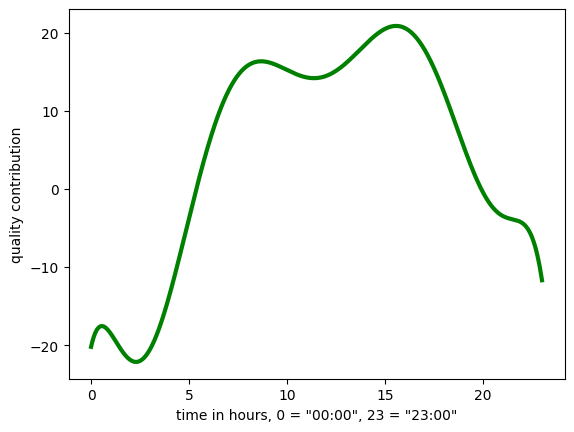

In [43]:
time_x = np.linspace(x_metro['time'].min(), x_metro['time'].max(), len(time_data['y']))
linefit = np.poly1d(np.polyfit(time_data['x'], time_data['y'], 8))
#plt.plot(alcohol_x, alcohol_data['y'])
plt.plot(time_x, linefit(time_data['x']), color = 'green', linewidth = 3)
#plt.xlim(7.8, 15)
#plt.ylim(-1, 1.5)
plt.xlabel('time in hours, 0 = "00:00", 23 = "23:00"')
plt.ylabel('quality contribution')
plt.show()

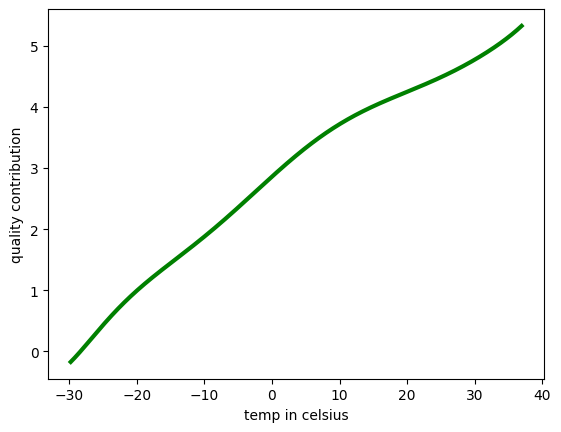

In [36]:
temp_x = np.linspace(x_metro['temp'].min() -273.15, x_metro['temp'].max() -273.15, len(temp_data['y']))
linefit = np.poly1d(np.polyfit(temp_data['x'], temp_data['y'], 8))
#plt.plot(alcohol_x, alcohol_data['y'])
plt.plot(temp_x, linefit(temp_data['x']), color = 'green', linewidth = 3)
#plt.xlim(7.8, 15)
#plt.ylim(-1, 1.5)
plt.xlabel('temp in celsius')
plt.ylabel('quality contribution')
plt.show()

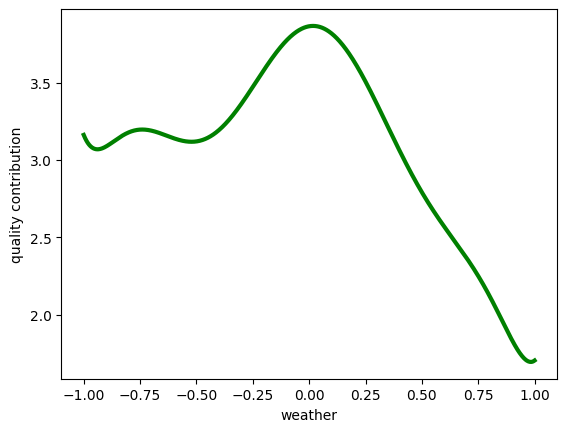

In [37]:
linefit = np.poly1d(np.polyfit(weather_data['x'], weather_data['y'], 8))
plt.plot(weather_data['x'], linefit(weather_data['x']), color = 'green', linewidth = 3)
plt.xlabel('weather')
plt.ylabel('quality contribution')
plt.show()




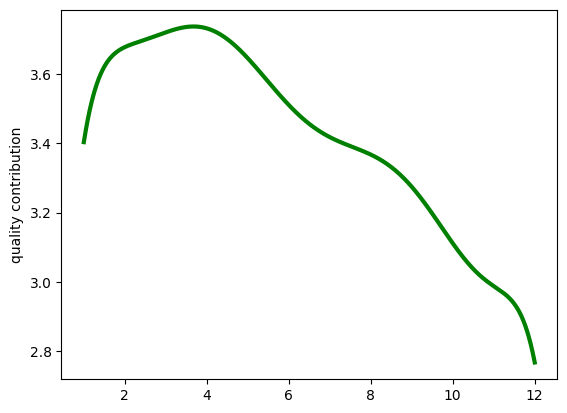

In [40]:
month_x = np.linspace(x_metro['month'].min(), x_metro['month'].max(), len(month_data['y']))
linefit = np.poly1d(np.polyfit(month_data['x'], month_data['y'], 8))
#plt.plot(alcohol_x, alcohol_data['y'])
plt.plot(month_x, linefit(month_data['x']), color = 'green', linewidth = 3)
#plt.xlim(7.8, 15)
#plt.ylim(-1, 1.5)

plt.ylabel('quality contribution')
plt.show()